In [1]:
!pip install gdown
import gdown
#from cld_data_processing import download_data

In [2]:
!rm -rf /kaggle/working/data
!rm /kaggle/working/data.zip

rm: cannot remove '/kaggle/working/data.zip': No such file or directory


In [3]:
import keras
import numpy as np
import pandas as pd
import random
import shutil
import tensorflow as tf
import os
import zipfile

from collections import Counter
from dataclasses import dataclass
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from tensorflow.keras import layers, callbacks
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image_dataset_from_directory

from tensorflow.data import Dataset

from typing import NamedTuple, Tuple

import matplotlib.pyplot as plt
import seaborn as sns

2024-03-23 20:56:19.781201: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-23 20:56:19.781330: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-23 20:56:19.944522: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
class Params(NamedTuple):
    """
    Job Parameters
    """
    image_size: int
    batch_size: int
    epochs: int
    early_stopping: bool
    early_stopping_patience: int
    adjust_learning_rate: bool

In [5]:
tf.random.set_seed(67890)

DEFAULT_PARAMS = Params(255, 196, 50, True, 5, False)
DEFAULT_PARAMS

Params(image_size=255, batch_size=196, epochs=50, early_stopping=True, early_stopping_patience=5, adjust_learning_rate=False)

`/data/data_processing.py`

In [6]:
def create_ds_tree(x, y, path, name) -> Path:
    """
    
    """
    ds_path = path / name
    if not ds_path.exists():
        ds_path.mkdir(parents=True, exist_ok=True)

        for lab in y.unique():
            (ds_path / str(lab)).mkdir(exist_ok=True)

        source_path = path / "train_images"
        
        for img, lab in zip(x, y):
            src = source_path / img
            dest = ds_path / str(lab) / img
            shutil.move(src, dest)
        
    return ds_path


def create_dataset(path: Path, img_size: int, batch_size: int = None) -> Dataset:
    """
    """
    return image_dataset_from_directory(
        path,
        labels='inferred',
        label_mode='categorical',
        image_size=[img_size, img_size],
        batch_size=batch_size,
    )


def augment_dataset(ds: Dataset, num_repeats: int) -> Dataset:
    def augment(image, label):
        seed = 12345
        image = tf.image.random_flip_left_right(image, seed)
        image = tf.image.random_flip_up_down(image, seed)
        image = tf.image.random_brightness(image, 0.2, seed)
        return image, label

    AUTOTUNE = tf.data.experimental.AUTOTUNE
    return (
        ds
        .repeat(num_repeats)
        .map(augment)
        .cache()
        .prefetch(buffer_size=AUTOTUNE)
    )
    
    
def download_data(path: Path, force=False) -> Path:
    """
    """
    url = "https://drive.google.com/uc?id=1TJBf1HZxAMpowZ92BcgS5N_NPHE7LPOT"
    output = path / "data.zip"
    if not Path(output).exists() or force:
        gdown.download(url, str(output), quiet=False)
    return output


def data_preprocessing(path: Path, params: Params, force=False) -> Tuple[Dataset, Dataset, Dataset]:
    """
    """
    file = download_data(path, force)
    
    data_path = path / "data"
    if force:
        shutil.rmtree(data_path)
        
    if not data_path.exists():
        data_path.mkdir(parents=True, exist_ok=True)
       
        with zipfile.ZipFile(file, "r") as z:
            z.extractall(data_path)
        
    df_images = pd.read_csv((data_path / "train.csv"))
    
#     imgs1 = random.sample(df_images[df_images.label==3].image_id.tolist(), k=2577)
#     imgs2 = df_images[df_images.label!=3].image_id.tolist()
    
#     df_images = df_images[df_images.image_id.isin((imgs1+imgs2))].copy()
    
    X_train, X_test, y_train, y_test = train_test_split(df_images.image_id, df_images.label, test_size=0.2, random_state=12)
    
    X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.25, random_state=12)
    
    train_path = create_ds_tree(X_train, y_train, data_path, "train")
    valid_path = create_ds_tree(X_valid, y_valid, data_path, "valid")
    test_path = create_ds_tree(X_test, y_test, data_path, "test")
    
    ds_train = create_dataset(train_path, params.image_size, params.batch_size)
    ds_valid = create_dataset(valid_path, params.image_size, params.batch_size)
    ds_test = create_dataset(test_path, params.image_size, params.batch_size)

    return ds_train, ds_valid, ds_test

In [7]:
# def data_cleanup() -> None:
#     # clean-up
#     try:
#         os.rmdir((data_path / "train_images"))
#         os.remove(file)
#     except Exception:
#          pass

`/model/utils.py`

In [8]:
def model_convnext_tiny(params: Params) -> Model:
    
    base_model = tf.keras.applications.ConvNeXtTiny(weights='imagenet', include_top=False)
    base_model.trainable = False
    
    img_size = params.image_size
    
    return keras.Sequential([
        
        tf.keras.Input(shape=(img_size, img_size, 3)),
        
        base_model,
        layers.GlobalAveragePooling2D(),

        # Classifier Head
        layers.Flatten(),
        layers.Dense(1024, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(1024, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(units=5, activation="softmax"),
    ])


def model_convnext_base(params: Params) -> Model:
    
    base_model = tf.keras.applications.ConvNeXtBase(weights='imagenet', include_top=False)
    base_model.trainable = False
    
    img_size = params.image_size
    
    return keras.Sequential([
        
        tf.keras.Input(shape=(img_size, img_size, 3)),
        
        base_model,
        layers.GlobalAveragePooling2D(),

        # Classifier Head
        layers.Flatten(),
        layers.Dense(1024, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(1024, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(units=5, activation="softmax"),
    ])


def model_convnext_tiny_1fc(params: Params) -> Model:
    
    base_model = tf.keras.applications.ConvNeXtTiny(weights='imagenet', include_top=False)
    base_model.trainable = False
    
    img_size = params.image_size
    
    return keras.Sequential([
        
        tf.keras.Input(shape=(img_size, img_size, 3)),
        
        base_model,
        layers.GlobalAveragePooling2D(),

        # Classifier Head
        layers.Flatten(),
        layers.Dense(1024, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(units=5, activation="softmax"),
    ])


def model_effnet(params: Params) -> Model:
    
    base_model = tf.keras.applications.EfficientNetB0(weights='imagenet', include_top=False)
    base_model.trainable = False
    
    img_size = params.image_size
    
    return keras.Sequential([
        
        tf.keras.Input(shape=(img_size, img_size, 3)),
        
        base_model,
        layers.GlobalAveragePooling2D(),

        # Classifier Head
        layers.Flatten(),
        layers.Dense(1024, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(1024, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(units=5, activation="softmax"),
    ])


def model_effnetv2(params: Params) -> Model:
    
    base_model = tf.keras.applications.EfficientNetV2B0(weights='imagenet', include_top=False)
    base_model.trainable = False
    
    img_size = params.image_size
    
    return keras.Sequential([
        
        tf.keras.Input(shape=(img_size, img_size, 3)),
        
        base_model,
        layers.GlobalAveragePooling2D(),

        # Classifier Head
        layers.Flatten(),
        layers.Dense(1024, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(1024, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(units=5, activation="softmax"),
    ])


def effnet2(params: Params) -> Model:
    base_model = tf.keras.applications.EfficientNetV2B0(weights='imagenet', include_top=False)
    base_model.trainable = False
    inputs = keras.Input(shape=(params.image_size, params.image_size, 3))
    x = base_model(inputs, training=False)
    x = keras.layers.GlobalAveragePooling2D()(x)
    x = keras.layers.Flatten()(x)
    x = keras.layers.Dense(1024, activation="relu")(x)
    x = keras.layers.Dropout(0.5)(x)
    x = keras.layers.Dense(1024, activation="relu")(x)
    x = keras.layers.Dropout(0.5)(x)
    outputs = keras.layers.Dense(5, activation="softmax")(x)
    model = keras.Model(inputs, outputs)
    return model
    

In [9]:
def run_experiment(exp_id: str, sub_exp_id: int, model_fn: str,
                      ds_train_: Dataset, ds_valid_: Dataset, params: Params, weights = None) -> Tuple[Model, pd.DataFrame]:
    
    model = model_fn(params)
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(epsilon=0.005),
        loss="categorical_crossentropy",
        metrics=['accuracy']
    )

    early_stopping = callbacks.EarlyStopping(
        min_delta=0.0001,
        patience=params.early_stopping_patience,
        restore_best_weights=True,
        verbose = 1
    )
    
    reduce_lr = callbacks.ReduceLROnPlateau(
        monitor = 'val_loss', factor = 0.3, 
        patience = 3, min_delta = 0.001, 
        mode = 'min', verbose = 1)
    
    cbs = []
    if params.early_stopping:
        print("Using EarlyStopping")
        cbs += [early_stopping]
    if params.adjust_learning_rate:
        print("Using ReduceLROnPlateau")
        cbs += [reduce_lr]

    history = model.fit(
        ds_train_,
        validation_data=ds_valid_,
        epochs=params.epochs,
        verbose=1,
        callbacks=cbs,
        class_weight = weights
    )
    
    df_hist = pd.DataFrame(history.history)
    df_hist = df_hist.reset_index()
    df_hist["exp_id"] = exp_id
    df_hist["sub_exp_id"] = sub_exp_id
    df_hist["epoch"] = df_hist.index
   
    return model, df_hist

In [10]:
def add_results(df_all_results, df_new_results):
    if df_all_results.empty:
        return df_new_results
    else:
        return pd.concat([df_all_results, df_new_results])
    

def add_test_results(df_all_results: pd.DataFrame, exp_id: str, res: list[float]):
    df_res = pd.DataFrame({"exp_id": [exp_id], "test_loss" : [res[0]], "test_accuracy": [res[1]]})
    if df_all_results.empty:
        return df_res
    else:
        return pd.concat([df_all_results, df_res])


def recover_results() -> pd.DataFrame:
    file = "results.csv"
    if Path(file).exists():
        return pd.read_csv(file)
    return pd.DataFrame()


def recover_test_results() -> pd.DataFrame:
    file = "test_results.csv"
    if Path(file).exists():
        return pd.read_csv(file)
    return pd.DataFrame()

In [11]:
def plot_experiment_results(df_history: pd.DataFrame, exp_id: str, epoch_limit = 50) -> None:
    df = df_history[(df_history.exp_id == exp_id) & (df_history.epoch <= epoch_limit)].copy()
    df["loss_gap"] = df.val_loss - df.loss
    df_loss = df[["epoch", "loss", "val_loss"]].groupby(["epoch"]).mean()
    df_loss_gap = df[["epoch", "loss_gap"]].groupby(["epoch"]).mean()
    df_acc = df[["epoch", "accuracy", "val_accuracy"]].groupby(["epoch"]).mean()
    df_loss.plot()
    df_loss_gap.plot()
    df_acc.plot();
    
def plot_experiments_comp(df_history: pd.DataFrame, exp_id: list, y_dim: str, epoch_limit = 50) -> None:
    df = df_history[(df_history.exp_id.isin(exp_id)) & (df_history.epoch <= epoch_limit)].copy()
    df["loss_gap"] = df.val_loss - df.loss
    df_grp = df[["epoch","exp_id", y_dim]].groupby(["epoch", "exp_id"]).mean()
    sns.lineplot(data=df_grp, x="epoch", y=y_dim, hue="exp_id")

In [12]:
def plot_experiments_comp2(df_history: pd.DataFrame, exp_id: list, epoch_limit = 50) -> None:
    df = df_history[(df_history.exp_id.isin(exp_id)) & (df_history.epoch <= epoch_limit)].copy()
    df["loss_gap"] = df.val_loss - df.loss
    df_grp = df[["epoch","exp_id", "val_accuracy", "val_loss", "loss_gap"]].groupby(["epoch", "exp_id"]).mean()
    fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(16, 8))
    sns.lineplot(data=df_grp, x="epoch", y="val_accuracy", hue="exp_id",  ax=ax1)
    sns.lineplot(data=df_grp, x="epoch", y="val_loss", hue="exp_id",  ax=ax2)
    sns.lineplot(data=df_grp, x="epoch", y="loss_gap", hue="exp_id",  ax=ax3)

`main.py`

In [13]:
cwd = os.getcwd()
ds_train, ds_valid, ds_test = data_preprocessing(Path(cwd), DEFAULT_PARAMS)

Downloading...
From (original): https://drive.google.com/uc?id=1TJBf1HZxAMpowZ92BcgS5N_NPHE7LPOT
From (redirected): https://drive.google.com/uc?id=1TJBf1HZxAMpowZ92BcgS5N_NPHE7LPOT&confirm=t&uuid=d08b86f9-9914-4563-953d-b237b4ee4d35
To: /kaggle/working/data.zip
100%|██████████| 2.56G/2.56G [02:20<00:00, 18.2MB/s]


Found 12837 files belonging to 5 classes.
Found 4280 files belonging to 5 classes.
Found 4280 files belonging to 5 classes.


In [14]:
df_train = pd.read_csv("data/train.csv")
df_train.groupby(['label']).count()

,image_id
label,
0,1087
1,2189
2,2386
3,13158
4,2577


In [ ]:
# augemented datasets
ds_train_aug = augment_dataset(ds_train, 1)
ds_train_aug_lg = augment_dataset(ds_train, 2)
ds_train_aug_xlg = augment_dataset(ds_train, 4)

In [15]:
df_train = pd.read_csv("data/train.csv")

labs = df_train.label.unique()
class_weights = class_weight.compute_class_weight(class_weight='balanced',
                                                 classes=labs,
                                                 y=df_train.label)

class_weights = dict(zip(labs, class_weights))

In [16]:
class_weights

{0: 3.9368905243790246,
 3: 0.3252317981456148,
 1: 1.954956601187757,
 2: 1.7935456831517183,
 4: 1.6606131160263873}

In [17]:
df_results = recover_results()
df_test_results = recover_test_results()

In [18]:
df_results.head()

""


In [19]:
df_test_results.head()

""


`experiments/tasks`

In [29]:
(m, df_hist) = run_experiment("model_convnext_tiny", 1, model_convnext_tiny, ds_train_aug_lg, ds_valid, DEFAULT_PARAMS)
df_results = add_results(df_results, df_hist)
    
df_results.to_csv("results.csv")

m.evaluate(ds_test)

111650432/111650432 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Using EarlyStopping
Epoch 1/50


I0000 00:00:1711200094.835247      95 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1711200094.872660      95 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711200094.873005      95 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711200094.873527      95 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 65/132 ━━━━━━━━━━━━━━━━━━━━ 44s 657ms/step - accuracy: 0.5214 - loss: 1.3579

W0000 00:00:1711200148.381500      94 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711200148.381904      94 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711200148.382499      94 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 727ms/step - accuracy: 0.5664 - loss: 1.2256

W0000 00:00:1711200196.208887      96 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711200196.209165      96 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711200196.209638      96 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711200217.137661      94 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711200217.137956      94 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711200217.138454      94 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


132/132 ━━━━━━━━━━━━━━━━━━━━ 154s 935ms/step - accuracy: 0.5668 - loss: 1.2242 - val_accuracy: 0.7012 - val_loss: 0.7939
Epoch 2/50
132/132 ━━━━━━━━━━━━━━━━━━━━ 80s 608ms/step - accuracy: 0.6809 - loss: 0.8463 - val_accuracy: 0.7175 - val_loss: 0.7446
Epoch 3/50
132/132 ━━━━━━━━━━━━━━━━━━━━ 80s 605ms/step - accuracy: 0.7027 - loss: 0.7864 - val_accuracy: 0.7285 - val_loss: 0.7149
Epoch 4/50
132/132 ━━━━━━━━━━━━━━━━━━━━ 80s 605ms/step - accuracy: 0.7176 - loss: 0.7507 - val_accuracy: 0.7371 - val_loss: 0.6951
Epoch 5/50
132/132 ━━━━━━━━━━━━━━━━━━━━ 80s 606ms/step - accuracy: 0.7277 - loss: 0.7172 - val_accuracy: 0.7400 - val_loss: 0.6825
Epoch 6/50
132/132 ━━━━━━━━━━━━━━━━━━━━ 80s 606ms/step - accuracy: 0.7388 - loss: 0.6978 - val_accuracy: 0.7486 - val_loss: 0.6684
Epoch 7/50
132/132 ━━━━━━━━━━━━━━━━━━━━ 80s 606ms/step - accuracy: 0.7479 - loss: 0.6775 - val_accuracy: 0.7533 - val_loss: 0.6610
Epoch 8/50
132/132 ━━━━━━━━━━━━━━━━━━━━ 80s 605ms/step - accuracy: 0.7530 - loss: 0.6578 - va

[0.5952966809272766, 0.782243013381958]

In [27]:
(m1, df_hist) = run_experiment("model_convnext_base_orig_img", 1, model_convnext_base, augment_dataset(ds_train, 4), ds_valid, DEFAULT_PARAMS)
df_results = add_results(df_results, df_hist)
    
df_results.to_csv("results.csv")

m1.evaluate(ds_test)

350926856/350926856 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step
Using EarlyStopping
Epoch 1/50


I0000 00:00:1711214781.691249     102 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


 34/136 ━━━━━━━━━━━━━━━━━━━━ 2:48 2s/step - accuracy: 0.2557 - loss: 1.6874

W0000 00:00:1711214837.318150     101 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711214837.318574     101 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711214837.319046     101 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711214837.319436     101 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711214837.319788     101 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711214837.320222     101 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711214837.320602     101 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711214837.321013     101 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3698 - loss: 1.4606

W0000 00:00:1711214999.429837     100 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711214999.430209     100 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711214999.430643     100 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711214999.431025     100 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711214999.431345     100 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711214999.431685     100 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711214999.432044     100 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711214999.432372     100 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


136/136 ━━━━━━━━━━━━━━━━━━━━ 265s 2s/step - accuracy: 0.3705 - loss: 1.4592 - val_accuracy: 0.5992 - val_loss: 1.0199
Epoch 2/50
136/136 ━━━━━━━━━━━━━━━━━━━━ 188s 1s/step - accuracy: 0.5982 - loss: 0.9939 - val_accuracy: 0.6791 - val_loss: 0.8811
Epoch 3/50
136/136 ━━━━━━━━━━━━━━━━━━━━ 188s 1s/step - accuracy: 0.6684 - loss: 0.8526 - val_accuracy: 0.6884 - val_loss: 0.8051
Epoch 4/50
136/136 ━━━━━━━━━━━━━━━━━━━━ 188s 1s/step - accuracy: 0.6972 - loss: 0.7805 - val_accuracy: 0.6921 - val_loss: 0.7817
Epoch 5/50
136/136 ━━━━━━━━━━━━━━━━━━━━ 188s 1s/step - accuracy: 0.7298 - loss: 0.7110 - val_accuracy: 0.7115 - val_loss: 0.7657
Epoch 6/50
136/136 ━━━━━━━━━━━━━━━━━━━━ 188s 1s/step - accuracy: 0.7475 - loss: 0.6722 - val_accuracy: 0.7245 - val_loss: 0.7402
Epoch 7/50
136/136 ━━━━━━━━━━━━━━━━━━━━ 188s 1s/step - accuracy: 0.7606 - loss: 0.6320 - val_accuracy: 0.7161 - val_loss: 0.7281
Epoch 8/50
136/136 ━━━━━━━━━━━━━━━━━━━━ 188s 1s/step - accuracy: 0.7806 - loss: 0.5813 - val_accuracy: 0.723

W0000 00:00:1711217277.059412     102 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711217277.059861     102 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711217277.060293     102 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711217277.061306     102 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711217277.061694     102 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711217277.062117     102 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711217277.062504     102 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711217277.062892     102 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


[0.7215401530265808, 0.7241219878196716]

In [20]:
(m1a, df_hist) = run_experiment("model_convnext_base_orig_img_all", 1, model_convnext_base, augment_dataset(ds_train, 1), ds_valid, DEFAULT_PARAMS, class_weights)
df_results = add_results(df_results, df_hist)
    
df_results.to_csv("results.csv")

m1.evaluate(ds_test)

350926856/350926856 ━━━━━━━━━━━━━━━━━━━━ 14s 0us/step
Using EarlyStopping
Epoch 1/50


I0000 00:00:1711227624.360684      95 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1711227624.417161      95 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711227624.417596      95 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711227624.418109      95 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


65/66 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.3319 - loss: 1.6443

W0000 00:00:1711227722.276896      97 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711227722.277367      97 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711227722.277945      97 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3332 - loss: 1.6419

W0000 00:00:1711227732.006296      96 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711227732.006683      96 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711227732.007162      96 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711227772.902360      98 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711227772.902647      98 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711227772.903088      98 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


66/66 ━━━━━━━━━━━━━━━━━━━━ 200s 2s/step - accuracy: 0.3346 - loss: 1.6396 - val_accuracy: 0.6374 - val_loss: 0.9871
Epoch 2/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 115s 2s/step - accuracy: 0.5740 - loss: 1.2167 - val_accuracy: 0.7145 - val_loss: 0.8195
Epoch 3/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 115s 2s/step - accuracy: 0.6340 - loss: 1.0771 - val_accuracy: 0.7407 - val_loss: 0.7413
Epoch 4/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 115s 2s/step - accuracy: 0.6668 - loss: 0.9988 - val_accuracy: 0.7397 - val_loss: 0.7155
Epoch 5/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 115s 2s/step - accuracy: 0.6838 - loss: 0.9517 - val_accuracy: 0.7463 - val_loss: 0.6998
Epoch 6/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 115s 2s/step - accuracy: 0.7012 - loss: 0.8923 - val_accuracy: 0.7636 - val_loss: 0.6419
Epoch 7/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 115s 2s/step - accuracy: 0.7110 - loss: 0.8794 - val_accuracy: 0.7624 - val_loss: 0.6394
Epoch 8/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 115s 2s/step - accuracy: 0.7203 - loss: 0.8381 - val_accuracy: 0.7736 - val_loss: 0.

NameError: name 'm1' is not defined

In [24]:
(m1b, df_hist) = run_experiment("model_convnext_base_orig_img_all_no_wgt", 1, model_convnext_base, augment_dataset(ds_train, 1), ds_valid, DEFAULT_PARAMS)
df_results = add_results(df_results, df_hist)
    
df_results.to_csv("results.csv")

m1b.evaluate(ds_test)

Using EarlyStopping
Epoch 1/50


W0000 00:00:1711229947.300463      96 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711229947.300811      96 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711229947.301428      96 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


65/66 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.5713 - loss: 1.2198

W0000 00:00:1711230040.703963      96 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711230040.704290      96 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711230040.704914      96 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5720 - loss: 1.2173

W0000 00:00:1711230049.812536      95 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711230049.813015      95 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711230049.813536      95 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711230080.166504      96 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711230080.166864      96 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711230080.167387      96 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


66/66 ━━━━━━━━━━━━━━━━━━━━ 164s 2s/step - accuracy: 0.5728 - loss: 1.2148 - val_accuracy: 0.7124 - val_loss: 0.7813
Epoch 2/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 115s 2s/step - accuracy: 0.6816 - loss: 0.8407 - val_accuracy: 0.7442 - val_loss: 0.6891
Epoch 3/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 115s 2s/step - accuracy: 0.7181 - loss: 0.7557 - val_accuracy: 0.7652 - val_loss: 0.6393
Epoch 4/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 115s 2s/step - accuracy: 0.7367 - loss: 0.7004 - val_accuracy: 0.7762 - val_loss: 0.5994
Epoch 5/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 115s 2s/step - accuracy: 0.7558 - loss: 0.6577 - val_accuracy: 0.7808 - val_loss: 0.5770
Epoch 6/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 115s 2s/step - accuracy: 0.7712 - loss: 0.6313 - val_accuracy: 0.7949 - val_loss: 0.5500
Epoch 7/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 115s 2s/step - accuracy: 0.7795 - loss: 0.6029 - val_accuracy: 0.7991 - val_loss: 0.5427
Epoch 8/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 115s 2s/step - accuracy: 0.7933 - loss: 0.5784 - val_accuracy: 0.8023 - val_loss: 0.

[0.4838571846485138, 0.8336448669433594]

In [21]:
(m2, df_hist) = run_experiment("model_convnext_tiny_aug_sm", 1, model_convnext_tiny, ds_train_aug, ds_valid, DEFAULT_PARAMS)
df_results = add_results(df_results, df_hist)

df_results.to_csv("results.csv")

m2.evaluate(ds_test)

Using EarlyStopping
Epoch 1/50


W0000 00:00:1710874636.063295     118 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 66/132 ━━━━━━━━━━━━━━━━━━━━ 32s 491ms/step - accuracy: 0.5368 - loss: 1.2958

W0000 00:00:1710874668.093300     120 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1710874668.093669     120 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1710874668.094114     120 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 439ms/step - accuracy: 0.5746 - loss: 1.1900

W0000 00:00:1710874698.354414     119 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1710874707.319694     118 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1710874707.320049     118 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1710874707.320558     118 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


132/132 ━━━━━━━━━━━━━━━━━━━━ 89s 545ms/step - accuracy: 0.5750 - loss: 1.1888 - val_accuracy: 0.6883 - val_loss: 0.8099
Epoch 2/50
132/132 ━━━━━━━━━━━━━━━━━━━━ 52s 391ms/step - accuracy: 0.6677 - loss: 0.8874 - val_accuracy: 0.7079 - val_loss: 0.7607
Epoch 3/50
132/132 ━━━━━━━━━━━━━━━━━━━━ 52s 391ms/step - accuracy: 0.6870 - loss: 0.8308 - val_accuracy: 0.7189 - val_loss: 0.7358
Epoch 4/50
132/132 ━━━━━━━━━━━━━━━━━━━━ 51s 390ms/step - accuracy: 0.7024 - loss: 0.7867 - val_accuracy: 0.7276 - val_loss: 0.7158
Epoch 5/50
132/132 ━━━━━━━━━━━━━━━━━━━━ 52s 391ms/step - accuracy: 0.7173 - loss: 0.7552 - val_accuracy: 0.7327 - val_loss: 0.7105
Epoch 6/50
132/132 ━━━━━━━━━━━━━━━━━━━━ 52s 391ms/step - accuracy: 0.7246 - loss: 0.7328 - val_accuracy: 0.7383 - val_loss: 0.6966
Epoch 7/50
132/132 ━━━━━━━━━━━━━━━━━━━━ 52s 392ms/step - accuracy: 0.7333 - loss: 0.7092 - val_accuracy: 0.7336 - val_loss: 0.7005
Epoch 8/50
132/132 ━━━━━━━━━━━━━━━━━━━━ 52s 391ms/step - accuracy: 0.7437 - loss: 0.6897 - val

[0.6461977362632751, 0.7649532556533813]

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to 

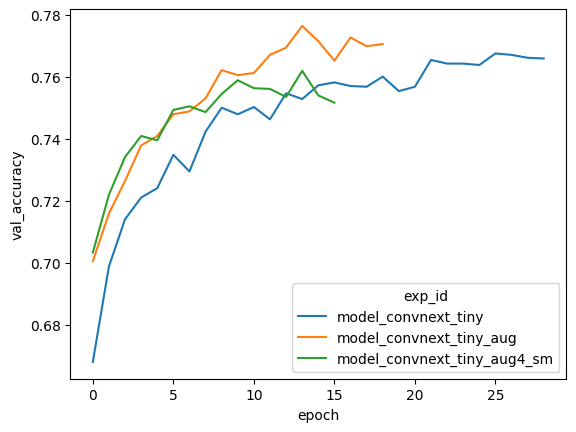

In [16]:
plot_experiments_comp(df_results,["model_convnext_tiny", "model_convnext_tiny_aug", "model_convnext_tiny_aug4_sm"], "val_accuracy")

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to 

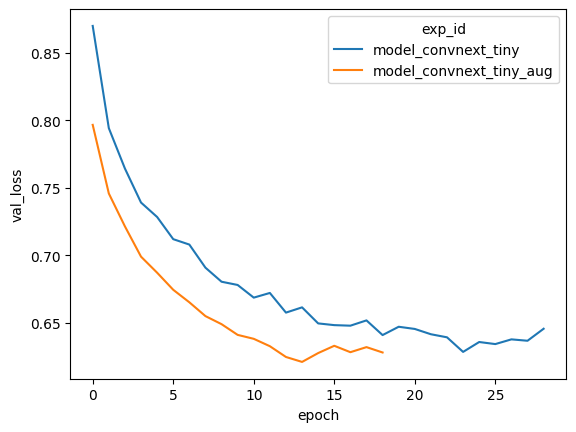

In [29]:
plot_experiments_comp(df_results,["model_convnext_tiny", "model_convnext_tiny_aug"], "val_loss")

In [14]:
(m3, df_hist) = run_experiment("model_convnext_tiny_aug4_sm", 1, model_convnext_tiny, ds_train_aug_lg, ds_valid, DEFAULT_PARAMS)
df_results = add_results(df_results, df_hist)

df_results.to_csv("results.csv")

m3.evaluate(ds_test)

111650432/111650432 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step
Using EarlyStopping
Epoch 1/50


I0000 00:00:1710876888.404715     112 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1710876888.443081     112 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 66/198 ━━━━━━━━━━━━━━━━━━━━ 1:11 543ms/step - accuracy: 0.5559 - loss: 1.2797

W0000 00:00:1710876923.920888     111 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1710876923.921192     111 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1710876923.921644     111 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1710876923.924526     111 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1710876923.924891     111 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1710876923.925388     111 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 441ms/step - accuracy: 0.6035 - loss: 1.1254

W0000 00:00:1710876980.605474     112 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1710876995.701193     113 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1710876995.701600     113 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1710876995.702038     113 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


198/198 ━━━━━━━━━━━━━━━━━━━━ 135s 545ms/step - accuracy: 0.6037 - loss: 1.1247 - val_accuracy: 0.7033 - val_loss: 0.7902
Epoch 2/50
198/198 ━━━━━━━━━━━━━━━━━━━━ 73s 370ms/step - accuracy: 0.6863 - loss: 0.8396 - val_accuracy: 0.7220 - val_loss: 0.7451
Epoch 3/50
198/198 ━━━━━━━━━━━━━━━━━━━━ 73s 370ms/step - accuracy: 0.7109 - loss: 0.7794 - val_accuracy: 0.7341 - val_loss: 0.7184
Epoch 4/50
198/198 ━━━━━━━━━━━━━━━━━━━━ 73s 369ms/step - accuracy: 0.7240 - loss: 0.7427 - val_accuracy: 0.7409 - val_loss: 0.6969
Epoch 5/50
198/198 ━━━━━━━━━━━━━━━━━━━━ 73s 370ms/step - accuracy: 0.7370 - loss: 0.7148 - val_accuracy: 0.7395 - val_loss: 0.6881
Epoch 6/50
198/198 ━━━━━━━━━━━━━━━━━━━━ 73s 369ms/step - accuracy: 0.7440 - loss: 0.6852 - val_accuracy: 0.7493 - val_loss: 0.6714
Epoch 7/50
198/198 ━━━━━━━━━━━━━━━━━━━━ 73s 370ms/step - accuracy: 0.7580 - loss: 0.6570 - val_accuracy: 0.7505 - val_loss: 0.6659
Epoch 8/50
198/198 ━━━━━━━━━━━━━━━━━━━━ 73s 370ms/step - accuracy: 0.7669 - loss: 0.6348 - va

[0.6419883370399475, 0.7633177638053894]

In [17]:
df_results.head()

,Unnamed: 0.1,Unnamed: 0,index,accuracy,loss,val_accuracy,val_loss,exp_id,sub_exp_id,epoch
0,0.0,0.0,0,0.594220,1.156284,0.667991,0.869793,model_convnext_tiny,1,0
1,1.0,1.0,1,0.660435,0.907906,0.698832,0.794085,model_convnext_tiny,1,1
2,2.0,2.0,2,0.681312,0.845324,0.714019,0.764165,model_convnext_tiny,1,2
3,3.0,3.0,3,0.695022,0.809372,0.721028,0.738957,model_convnext_tiny,1,3
4,4.0,4.0,4,0.707954,0.784043,0.724065,0.728263,model_convnext_tiny,1,4


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to 

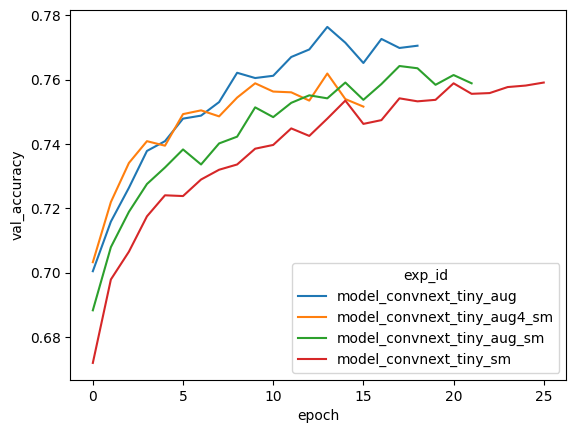

In [19]:
plot_experiments_comp(df_results,["model_convnext_tiny_aug", "model_convnext_tiny_sm", "model_convnext_tiny_aug_sm", "model_convnext_tiny_aug4_sm"], "val_accuracy")

In [22]:
(m4, df_hist) = run_experiment("model_convnext_tiny_1fc", 1, model_convnext_tiny_1fc, ds_train_aug_lg, ds_valid, DEFAULT_PARAMS)
df_results = add_results(df_results, df_hist)

df_results.to_csv("results.csv")

m4.evaluate(ds_test)

Using EarlyStopping
Epoch 1/50


W0000 00:00:1710879459.300541     113 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 66/198 ━━━━━━━━━━━━━━━━━━━━ 54s 413ms/step - accuracy: 0.5653 - loss: 1.2253

W0000 00:00:1710879486.287257     113 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1710879486.287631     113 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1710879486.288096     113 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1710879486.291170     113 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1710879486.291581     113 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1710879486.292051     113 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 356ms/step - accuracy: 0.6132 - loss: 1.0714

W0000 00:00:1710879534.739911     112 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1710879544.430567     113 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1710879544.430939     113 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1710879544.431438     113 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


198/198 ━━━━━━━━━━━━━━━━━━━━ 100s 433ms/step - accuracy: 0.6134 - loss: 1.0708 - val_accuracy: 0.7112 - val_loss: 0.7692
Epoch 2/50
198/198 ━━━━━━━━━━━━━━━━━━━━ 73s 369ms/step - accuracy: 0.7007 - loss: 0.8009 - val_accuracy: 0.7334 - val_loss: 0.7269
Epoch 3/50
198/198 ━━━━━━━━━━━━━━━━━━━━ 73s 369ms/step - accuracy: 0.7246 - loss: 0.7440 - val_accuracy: 0.7393 - val_loss: 0.7025
Epoch 4/50
198/198 ━━━━━━━━━━━━━━━━━━━━ 73s 370ms/step - accuracy: 0.7400 - loss: 0.7050 - val_accuracy: 0.7439 - val_loss: 0.6898
Epoch 5/50
198/198 ━━━━━━━━━━━━━━━━━━━━ 73s 370ms/step - accuracy: 0.7497 - loss: 0.6771 - val_accuracy: 0.7500 - val_loss: 0.6750
Epoch 6/50
198/198 ━━━━━━━━━━━━━━━━━━━━ 73s 370ms/step - accuracy: 0.7605 - loss: 0.6484 - val_accuracy: 0.7565 - val_loss: 0.6653
Epoch 7/50
198/198 ━━━━━━━━━━━━━━━━━━━━ 73s 369ms/step - accuracy: 0.7705 - loss: 0.6276 - val_accuracy: 0.7535 - val_loss: 0.6590
Epoch 8/50
198/198 ━━━━━━━━━━━━━━━━━━━━ 73s 369ms/step - accuracy: 0.7789 - loss: 0.6072 - va

[0.6196820735931396, 0.7740654349327087]

In [ ]:
plot_experiments_comp2(df_results,["model_convnext_tiny_1fc", "model_convnext_tiny_aug", "model_convnext_tiny_sm", "model_convnext_tiny_aug_sm", "model_convnext_tiny_aug4_sm"], "val_loss")

In [20]:
(m4, df_hist) = run_experiment("model_effnetv2", 1, model_effnetv2, ds_train_aug_lg, ds_valid, DEFAULT_PARAMS)
df_results = add_results(df_results, df_hist)
    
df_results.to_csv("results.csv")

m4.evaluate(ds_test)

24274472/24274472 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Using EarlyStopping
Epoch 1/50
  1/198 ━━━━━━━━━━━━━━━━━━━━ 3:09:04 58s/step - accuracy: 0.1939 - loss: 1.6959

I0000 00:00:1711014696.039457      93 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1711014696.105978      93 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 558ms/step - accuracy: 0.5954 - loss: 1.1344

W0000 00:00:1711014813.255352      95 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


198/198 ━━━━━━━━━━━━━━━━━━━━ 191s 677ms/step - accuracy: 0.5956 - loss: 1.1337 - val_accuracy: 0.7152 - val_loss: 0.7667
Epoch 2/50
198/198 ━━━━━━━━━━━━━━━━━━━━ 27s 134ms/step - accuracy: 0.6883 - loss: 0.8371 - val_accuracy: 0.7357 - val_loss: 0.7159
Epoch 3/50
198/198 ━━━━━━━━━━━━━━━━━━━━ 27s 134ms/step - accuracy: 0.7128 - loss: 0.7732 - val_accuracy: 0.7505 - val_loss: 0.6841
Epoch 4/50
198/198 ━━━━━━━━━━━━━━━━━━━━ 27s 135ms/step - accuracy: 0.7256 - loss: 0.7388 - val_accuracy: 0.7547 - val_loss: 0.6710
Epoch 5/50
198/198 ━━━━━━━━━━━━━━━━━━━━ 27s 134ms/step - accuracy: 0.7373 - loss: 0.7103 - val_accuracy: 0.7607 - val_loss: 0.6610
Epoch 6/50
198/198 ━━━━━━━━━━━━━━━━━━━━ 27s 134ms/step - accuracy: 0.7461 - loss: 0.6839 - val_accuracy: 0.7586 - val_loss: 0.6526
Epoch 7/50
198/198 ━━━━━━━━━━━━━━━━━━━━ 27s 134ms/step - accuracy: 0.7556 - loss: 0.6642 - val_accuracy: 0.7631 - val_loss: 0.6459
Epoch 8/50
198/198 ━━━━━━━━━━━━━━━━━━━━ 27s 135ms/step - accuracy: 0.7620 - loss: 0.6503 - va

[0.602713406085968, 0.7939252257347107]

In [23]:
(m5, df_hist) = run_experiment("model_effnet", 1, model_effnet, ds_train_aug_lg, ds_valid, DEFAULT_PARAMS)
df_results = add_results(df_results, df_hist)

df_results.to_csv("results.csv")

r5 = m5.evaluate(ds_test)
df_test_results = add_test_results(df_test_results, "model_effnet", r5)
print(r5)

22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 138ms/step - accuracy: 0.7699 - loss: 0.6439
[0.6315759420394897, 0.7749999761581421]


In [24]:
(m6, df_hist) = run_experiment("model_effnet_wgts", 1, model_effnet, ds_train_aug_lg, ds_valid, DEFAULT_PARAMS, class_weights)
df_results = add_results(df_results, df_hist)
    
df_results.to_csv("results.csv")

r6 = m6.evaluate(ds_test)
df_test_results = add_test_results(df_test_results, "model_effnet", r6)
print(r6)

Using EarlyStopping


W0000 00:00:1711120373.911076      96 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711120424.326112      94 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


Epoch 11: early stopping
Restoring model weights from the end of the best epoch: 6.
22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 145ms/step - accuracy: 0.7016 - loss: 0.7855
[0.6315759420394897, 0.7749999761581421]


In [29]:
print(r6)

[0.7759647369384766, 0.7074766159057617]


In [ ]:
(m7, df_hist) = run_experiment("effnet2", 1, effnet2, ds_train_aug_lg, ds_valid, DEFAULT_PARAMS, class_weights)
df_results = add_results(df_results, df_hist)
    
df_results.to_csv("results.csv")

r7 = m7.evaluate(ds_test)
df_test_results = add_test_results(df_test_results, "effnet2", r6)
print(r7)

In [ ]:
plot_experiments_comp2(df_results,["model_effnet", "model_effnet_wgts"])

In [ ]:
plot_experiments_comp2(df_results,["model_convnext_tiny_1fc", "model_convnext_tiny_aug", "model_effnetv2", "model_effnet"])

In [16]:
params = DEFAULT_PARAMS
weights = class_weights
    
base_model = tf.keras.applications.EfficientNetV2B0(weights='imagenet', include_top=False)
base_model.trainable = False
inputs = keras.Input(shape=(params.image_size, params.image_size, 3))
x = base_model(inputs, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Flatten()(x)
#x = keras.layers.Dense(1024, activation="relu")(x)
#x = keras.layers.Dropout(0.5)(x)
x = keras.layers.Dense(1024, activation="relu")(x)
x = keras.layers.Dropout(0.5)(x)
outputs = keras.layers.Dense(5, activation="softmax")(x)
model = keras.Model(inputs, outputs)

model.compile(
    optimizer=tf.keras.optimizers.Adam(epsilon=0.005),
    loss="categorical_crossentropy",
    metrics=['accuracy']
)

early_stopping = callbacks.EarlyStopping(
    min_delta=0.0001,
    patience=params.early_stopping_patience,
    restore_best_weights=True,
    verbose = 1
)

reduce_lr = callbacks.ReduceLROnPlateau(
    monitor = 'val_loss', factor = 0.3, 
    patience = 3, min_delta = 0.001, 
    mode = 'min', verbose = 1)

cbs = []
if params.early_stopping:
    print("Using EarlyStopping")
    cbs += [early_stopping]
if params.adjust_learning_rate:
    print("Using ReduceLROnPlateau")
    cbs += [reduce_lr]

history = model.fit(
    ds_train_aug_lg,
    validation_data=ds_valid,
    epochs=params.epochs,
    verbose=1,
    callbacks=cbs,
    class_weight = None
)


24274472/24274472 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Using EarlyStopping
Epoch 1/50
  1/132 ━━━━━━━━━━━━━━━━━━━━ 2:06:05 58s/step - accuracy: 0.2143 - loss: 1.6353

I0000 00:00:1711183890.688968      94 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


132/132 ━━━━━━━━━━━━━━━━━━━━ 177s 909ms/step - accuracy: 0.5993 - loss: 1.1115 - val_accuracy: 0.7215 - val_loss: 0.7674
Epoch 2/50
132/132 ━━━━━━━━━━━━━━━━━━━━ 24s 179ms/step - accuracy: 0.6981 - loss: 0.8225 - val_accuracy: 0.7353 - val_loss: 0.7201
Epoch 3/50
132/132 ━━━━━━━━━━━━━━━━━━━━ 23s 176ms/step - accuracy: 0.7146 - loss: 0.7664 - val_accuracy: 0.7465 - val_loss: 0.6950
Epoch 4/50
132/132 ━━━━━━━━━━━━━━━━━━━━ 23s 178ms/step - accuracy: 0.7284 - loss: 0.7407 - val_accuracy: 0.7493 - val_loss: 0.6777
Epoch 5/50
132/132 ━━━━━━━━━━━━━━━━━━━━ 23s 178ms/step - accuracy: 0.7353 - loss: 0.7106 - val_accuracy: 0.7582 - val_loss: 0.6691
Epoch 6/50
132/132 ━━━━━━━━━━━━━━━━━━━━ 23s 177ms/step - accuracy: 0.7456 - loss: 0.6929 - val_accuracy: 0.7614 - val_loss: 0.6577
Epoch 7/50
132/132 ━━━━━━━━━━━━━━━━━━━━ 24s 179ms/step - accuracy: 0.7517 - loss: 0.6728 - val_accuracy: 0.7629 - val_loss: 0.6525
Epoch 8/50
132/132 ━━━━━━━━━━━━━━━━━━━━ 23s 177ms/step - accuracy: 0.7550 - loss: 0.6597 - va

In [22]:
model.evaluate(ds_test)

22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 171ms/step - accuracy: 0.7863 - loss: 0.5973


[0.5956586003303528, 0.788551390171051]

In [ ]:
base_model.trainable = True

model.compile(
    optimizer=tf.keras.optimizers.Adam(epsilon=1e-5),
    loss="categorical_crossentropy",
    metrics=['accuracy']
)

history2 = model.fit(
    ds_train_aug_lg,
    validation_data=ds_valid,
    epochs=params.epochs,
    verbose=1,
    callbacks=cbs,
    class_weight=None
)

Epoch 1/50
132/132 ━━━━━━━━━━━━━━━━━━━━ 271s 1s/step - accuracy: 0.7378 - loss: 0.7296 - val_accuracy: 0.8264 - val_loss: 0.5269
Epoch 2/50
132/132 ━━━━━━━━━━━━━━━━━━━━ 64s 484ms/step - accuracy: 0.8877 - loss: 0.3190 - val_accuracy: 0.8079 - val_loss: 0.7418
Epoch 3/50
132/132 ━━━━━━━━━━━━━━━━━━━━ 64s 484ms/step - accuracy: 0.9325 - loss: 0.1911 - val_accuracy: 0.8049 - val_loss: 0.8299
Epoch 4/50
  9/132 ━━━━━━━━━━━━━━━━━━━━ 55s 449ms/step - accuracy: 0.9554 - loss: 0.1321

In [ ]:
model.evaluate(ds_test)
# [0.4968397915363312, 0.8268691301345825]

In [30]:
model_eff = model

In [37]:
params = DEFAULT_PARAMS
weights = class_weights
    
base_model = tf.keras.applications.ConvNeXtTiny(weights='imagenet', include_top=False)
base_model.trainable = False
inputs = keras.Input(shape=(params.image_size, params.image_size, 3))
x = base_model(inputs, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Flatten()(x)
x = keras.layers.Dense(1024, activation="relu")(x)
x = keras.layers.Dropout(0.5)(x)
x = keras.layers.Dense(1024, activation="relu")(x)
x = keras.layers.Dropout(0.5)(x)
outputs = keras.layers.Dense(5, activation="softmax")(x)
model = keras.Model(inputs, outputs)

model.compile(
    optimizer=tf.keras.optimizers.Adam(epsilon=0.005),
    loss="categorical_crossentropy",
    metrics=['accuracy']
)

early_stopping = callbacks.EarlyStopping(
    min_delta=0.0001,
    patience=params.early_stopping_patience,
    restore_best_weights=True,
    verbose = 1
)

reduce_lr = callbacks.ReduceLROnPlateau(
    monitor = 'val_loss', factor = 0.3, 
    patience = 3, min_delta = 0.001, 
    mode = 'min', verbose = 1)

cbs = []
if params.early_stopping:
    print("Using EarlyStopping")
    cbs += [early_stopping]
if params.adjust_learning_rate:
    print("Using ReduceLROnPlateau")
    cbs += [reduce_lr]

history = model.fit(
    ds_train_aug_lg,
    validation_data=ds_valid,
    epochs=params.epochs,
    verbose=1,
    callbacks=cbs,
    class_weight = weights
)

Using EarlyStopping
Epoch 1/50


W0000 00:00:1711129663.129932      95 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711129663.130308      95 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711129663.130791      95 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711129663.131787      95 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711129663.132150      95 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711129663.132499      95 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711129663.132870      95 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711129663.133271      95 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 66/132 ━━━━━━━━━━━━━━━━━━━━ 23s 363ms/step - accuracy: 0.3009 - loss: 1.6923

W0000 00:00:1711129686.826409      92 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711129686.826809      92 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711129686.827283      92 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711129686.828341      92 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711129686.828728      92 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711129686.829100      92 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711129686.829480      92 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711129686.829858      92 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step - accuracy: 0.3471 - loss: 1.5952

W0000 00:00:1711129707.785721      92 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711129707.786046      92 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711129707.786476      92 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711129707.787508      92 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711129707.787887      92 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711129707.788245      92 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711129707.788621      92 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711129707.788979      92 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


132/132 ━━━━━━━━━━━━━━━━━━━━ 69s 394ms/step - accuracy: 0.3476 - loss: 1.5942 - val_accuracy: 0.5930 - val_loss: 1.1016
Epoch 2/50
132/132 ━━━━━━━━━━━━━━━━━━━━ 57s 265ms/step - accuracy: 0.5281 - loss: 1.2745 - val_accuracy: 0.6400 - val_loss: 0.9993
Epoch 3/50
132/132 ━━━━━━━━━━━━━━━━━━━━ 35s 264ms/step - accuracy: 0.5692 - loss: 1.2036 - val_accuracy: 0.6280 - val_loss: 0.9979
Epoch 4/50
132/132 ━━━━━━━━━━━━━━━━━━━━ 35s 265ms/step - accuracy: 0.5851 - loss: 1.1537 - val_accuracy: 0.6414 - val_loss: 0.9622
Epoch 5/50
132/132 ━━━━━━━━━━━━━━━━━━━━ 35s 264ms/step - accuracy: 0.5988 - loss: 1.1101 - val_accuracy: 0.6629 - val_loss: 0.9024
Epoch 6/50
132/132 ━━━━━━━━━━━━━━━━━━━━ 41s 265ms/step - accuracy: 0.6149 - loss: 1.0643 - val_accuracy: 0.6617 - val_loss: 0.8942
Epoch 7/50
132/132 ━━━━━━━━━━━━━━━━━━━━ 35s 266ms/step - accuracy: 0.6263 - loss: 1.0411 - val_accuracy: 0.6530 - val_loss: 0.8976
Epoch 8/50
132/132 ━━━━━━━━━━━━━━━━━━━━ 35s 264ms/step - accuracy: 0.6385 - loss: 1.0009 - val

In [38]:
model.evaluate(ds_test)

22/22 ━━━━━━━━━━━━━━━━━━━━ 6s 224ms/step - accuracy: 0.6931 - loss: 0.8042


[0.8152596950531006, 0.6834112405776978]

In [40]:
base_model.trainable = True

model.compile(
    optimizer=tf.keras.optimizers.Adam(epsilon=1e-5),
    loss="categorical_crossentropy",
    metrics=['accuracy']
)

history2 = model.fit(
    ds_train_aug_lg,
    validation_data=ds_valid,
    epochs=params.epochs,
    verbose=1,
    callbacks=cbs,
    class_weight = weights
)

Epoch 1/50


W0000 00:00:1711130378.083952      93 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711130378.084476      93 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711130378.084992      93 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711130378.086176      93 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711130378.086624      93 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711130378.087055      93 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711130378.087476      93 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711130378.087911      93 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 65/132 ━━━━━━━━━━━━━━━━━━━━ 52s 782ms/step - accuracy: 0.3593 - loss: 1.7604

W0000 00:00:1711130447.734415      94 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711130447.734816      94 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711130447.735313      94 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711130447.736380      94 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711130447.736795      94 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711130447.737189      94 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711130447.737597      94 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711130447.737981      94 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 920ms/step - accuracy: 0.4407 - loss: 1.5409

W0000 00:00:1711130503.592415      92 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711130503.592805      92 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711130503.593244      92 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711130503.594205      92 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711130503.594564      92 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711130503.594898      92 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711130503.595221      92 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711130503.595559      92 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


132/132 ━━━━━━━━━━━━━━━━━━━━ 179s 1s/step - accuracy: 0.4417 - loss: 1.5386 - val_accuracy: 0.7173 - val_loss: 0.7817
Epoch 2/50
132/132 ━━━━━━━━━━━━━━━━━━━━ 108s 818ms/step - accuracy: 0.7630 - loss: 0.7938 - val_accuracy: 0.6696 - val_loss: 1.0256
Epoch 3/50
132/132 ━━━━━━━━━━━━━━━━━━━━ 108s 819ms/step - accuracy: 0.8357 - loss: 0.4933 - val_accuracy: 0.7187 - val_loss: 0.8857
Epoch 4/50
132/132 ━━━━━━━━━━━━━━━━━━━━ 108s 818ms/step - accuracy: 0.8496 - loss: 0.3690 - val_accuracy: 0.7610 - val_loss: 0.7906
Epoch 5/50
132/132 ━━━━━━━━━━━━━━━━━━━━ 108s 818ms/step - accuracy: 0.8990 - loss: 0.2805 - val_accuracy: 0.7575 - val_loss: 0.9922
Epoch 6/50
132/132 ━━━━━━━━━━━━━━━━━━━━ 108s 821ms/step - accuracy: 0.9133 - loss: 0.2312 - val_accuracy: 0.7928 - val_loss: 0.9211
Epoch 6: early stopping
Restoring model weights from the end of the best epoch: 1.


In [41]:
model.evaluate(ds_test)

22/22 ━━━━━━━━━━━━━━━━━━━━ 6s 223ms/step - accuracy: 0.7304 - loss: 0.7642


[0.7482553124427795, 0.7350467443466187]

In [ ]:
@dataclass
class ModelWrapper():
    
    model: tensorflow.keras.models.Model
    base_model: tensorflow.keras.models.Model
    

In [49]:
preds = model.predict(ds_test)

22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step


In [63]:
m1.evaluate(ds_test)

12/12 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - accuracy: 0.7238 - loss: 0.7385


[0.7171044945716858, 0.7241219878196716]

In [40]:
m1.evaluate(ds_valid)

12/12 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - accuracy: 0.7191 - loss: 0.7681


[0.7590789198875427, 0.7235321402549744]

In [64]:
probabilities = m1.predict(ds_test)
predictions = np.argmax(probabilities, axis=1)
Counter(predictions)

12/12 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step


Counter({4: 570, 3: 502, 2: 437, 1: 424, 0: 231})

In [50]:
xs = np.concatenate([x for x, y in ds_test], axis=0)

In [84]:
probabilities = m1.predict(ds_test2)
predictions = np.argmax(probabilities, axis=1)
Counter(predictions)

12/12 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step


Counter({4: 570, 3: 502, 2: 437, 1: 424, 0: 231})

In [82]:
probabilities = m1a.predict(ds_test2)
predictions = np.argmax(probabilities, axis=1)
Counter(predictions)

3

In [85]:
y = np.concatenate([y for x, y in ds_test2], axis=0)
ys = [np.argmax(x) for x in y]

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
#Create confusion matrix and normalizes it over predicted (columns)
result = confusion_matrix(ys, predictions, labels=[0,1,2,3,4], normalize='pred')
print(result)

[[0.57142857 0.06132075 0.00228833 0.01195219 0.09473684]
 [0.17316017 0.71933962 0.02974828 0.02390438 0.10877193]
 [0.05194805 0.05424528 0.77116705 0.06972112 0.11578947]
 [0.02597403 0.05188679 0.10526316 0.85258964 0.04035088]
 [0.17748918 0.11320755 0.09153318 0.04183267 0.64035088]]


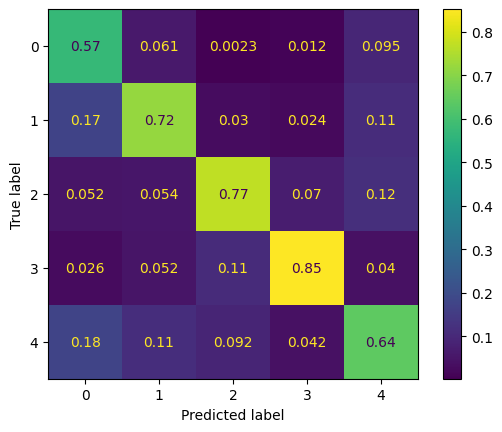

In [86]:
disp = ConfusionMatrixDisplay(result, display_labels=[0,1,2,3,4])
disp.plot()
plt.show()

In [21]:
ds_test2 = image_dataset_from_directory(
        Path("/kaggle/working/data/test/"),
        labels='inferred',
        label_mode='categorical',
        image_size=[255, 255],
        batch_size=196,
        shuffle=False
    )

Found 4280 files belonging to 5 classes.


In [23]:
m1a.evaluate(ds_test2)

22/22 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - accuracy: 0.7753 - loss: 0.6190


[0.5669453144073486, 0.8011682033538818]

 1/22 ━━━━━━━━━━━━━━━━━━━━ 2:17 7s/step

W0000 00:00:1711229620.339363      97 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711229620.339743      97 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711229620.340176      97 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


22/22 ━━━━━━━━━━━━━━━━━━━━ 38s 1s/step


W0000 00:00:1711229651.775553      97 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711229651.775867      97 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711229651.776368      97 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


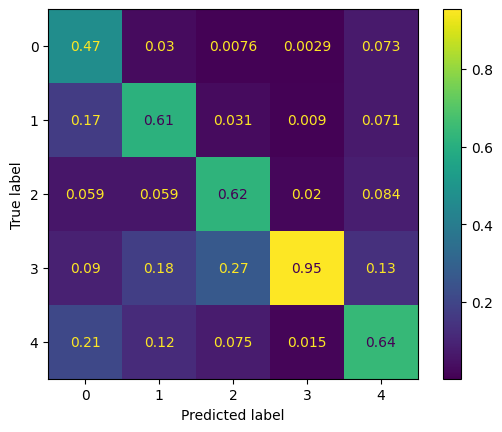

In [22]:
probabilities = m1a.predict(ds_test2)
predictions = np.argmax(probabilities, axis=1)
#Counter(predictions)

y = np.concatenate([y for x, y in ds_test2], axis=0)
ys = [np.argmax(x) for x in y]

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
#Create confusion matrix and normalizes it over predicted (columns)
result = confusion_matrix(ys, predictions, labels=[0,1,2,3,4], normalize='pred')
disp = ConfusionMatrixDisplay(result, display_labels=[0,1,2,3,4])
disp.plot()
plt.show()

In [25]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def plot_confusion_matrix(ds: Dataset, model: Model) -> None:
    probabilities = model.predict(ds)
    predictions = np.argmax(probabilities, axis=1)

    one_hot_labels = np.concatenate([y for x, y in ds], axis=0)
    labels = [np.argmax(x) for x in one_hot_labels]
    
    result = confusion_matrix(labels, predictions, labels=[0,1,2,3,4], normalize='pred')
    disp = ConfusionMatrixDisplay(result, display_labels=[0,1,2,3,4])
    disp.plot()
    plt.show()

In [27]:
m1b.evaluate(ds_valid)

22/22 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step - accuracy: 0.8130 - loss: 0.5056


[0.49226006865501404, 0.8212617039680481]

In [28]:
m1b.evaluate(ds_test)

22/22 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step - accuracy: 0.8371 - loss: 0.4861


[0.4821724593639374, 0.8336448669433594]

 1/22 ━━━━━━━━━━━━━━━━━━━━ 2:06 6s/step

W0000 00:00:1711232948.205983      96 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711232948.206470      96 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711232948.206970      96 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


22/22 ━━━━━━━━━━━━━━━━━━━━ 37s 1s/step


W0000 00:00:1711232978.741965      97 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711232978.742349      97 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711232978.742818      97 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


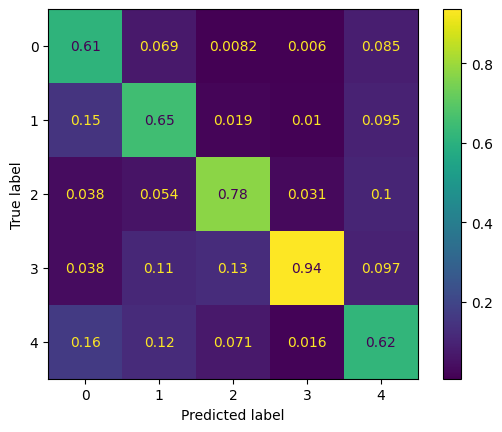

In [26]:
plot_confusion_matrix(ds_test2, m1b)